In [1]:
# To Stop GPUs working

In [2]:
# from numba import cuda
# cuda.select_device(0)
# cuda.close()

# Libraries

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import glob
import PIL # pillow - image processing
import tensorflow as tf
from PIL import Image
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import matplotlib
import matplotlib.pyplot as plt
from keras.optimizers import Adam
import pydot

tf.random.set_seed(123)

Using TensorFlow backend.


In [4]:
import os,datetime
#os.chdir(r"D:\PhD Classes (Big_files)\Neural Networks\Neural Networks\Project\2nd_dataset_image\Cropped_1Channel_Mask")
#os.chdir(r'/home/said.mejia/Projects/Deep_Learning/Dataset')
print(os.path.dirname(os.getcwd()))

C:\Users\said_\Google Drive\THE CITY COLLEGE OF NEW YORK\Ph.D.Classes\Spring21\Neural Networks\Project\Repo_CCNY_4\final-project-landandbuildingsatimg-ccny\notebooks


In [5]:
import sys
sys.path
sys.path.append(r'../../src/')

In [6]:
from visualization import visualize

In [7]:
from models.keras_segmentation.models.segnet import resnet50_segnet
from models.keras_segmentation.models.segnet import vgg_segnet
from models.keras_segmentation.models.unet import resnet50_unet
from models.keras_segmentation.models.unet import vgg_unet
from models.keras_segmentation.models.pspnet import resnet50_pspnet
from models.keras_segmentation.models.pspnet import vgg_pspnet

Segmentation Models: using `keras` framework.


# Select the folder that you are working on

In [8]:
folder_dataset = 'Balanced_80'

# PLEASE READ LINE BELLOW

### Before use this notebook, please create a folder in githubfolder/models/Save_Models or run the following commented line

In [9]:
folder_name = 'Save_Balanced_80_SM_JP'
#os.mkdir(r'../../models/'f'{folder_name}')

# Reading Images and Masks

In [10]:
reading_images = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Images/*.png'))
reading_masks = sorted(glob.glob(r'../../data/processed/'f'{folder_dataset}''/test/Masks/*.png'))
# reading_weights = (glob.glob(r'../../data/processed/Cropped_same_name/train/Sample_Weights/*.npy'))
img_num = 8

In [11]:
img = PIL.Image.open(reading_images[img_num], 'r')
mask = PIL.Image.open(reading_masks[img_num], 'r')

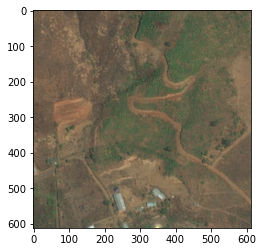

In [12]:
plt.imshow(np.asarray(img))

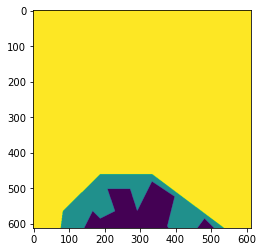

In [13]:
plt.imshow(np.asarray(mask))

# GPU

In [14]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  # Restrict TensorFlow to only use the first GPU
  try:
    tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")    
  except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized
    print(e)
    
tf.config.set_soft_device_placement(True)

1 Physical GPUs, 1 Logical GPU


# History Function

In [15]:
def plot_history(history, title):
       
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig = plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc)
    plt.plot(val_acc)
    plt.ylabel('iou_score')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.title(title)

    plt.subplot(1, 2, 2)
    plt.plot(loss)
    plt.plot(val_loss)
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    
    plt.savefig('../../models/'f'{folder_name}''/' + title + '.png', dpi = 300)
    plt.show();

## Ploting the class labels

In [16]:
labels = pd.read_csv('../../data/processed/'f'{folder_dataset}''/class_dict.csv')
classes = list(labels['name'])
classes

['unknown',
 'urban_land',
 'agriculture_land',
 'rangeland',
 'forest_land',
 'water',
 'barren_land']

In [17]:
labels = classes
col_dict = {0: 'blue', 1: 'red', 2: 'orange', 3: 'green', 
           4: 'yellow', 5: 'purple', 6: 'grey', }
col_dict

{0: 'blue',
 1: 'red',
 2: 'orange',
 3: 'green',
 4: 'yellow',
 5: 'purple',
 6: 'grey'}

# Paths

In [18]:
model_balanced_name = ['resnet50_segnet','vgg_segnet','vgg_unet','resnet50_unet','resnet50_pspnet','vgg_pspnet']

# ResNet_Segnet

In [19]:
i = 0

In [20]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [24]:
model = resnet50_segnet(n_classes=7 , input_height=512, input_width=512)
model.summary()

Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 512, 512, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_7 (ZeroPadding2D (None, 518, 518, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 256, 64) 9472        zero_padding2d_7[0][0]           
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 256, 256, 64) 256         conv1[0][0]                      
____________________________________________________________________________________________

In [22]:
from tensorflow.keras.utils import plot_model

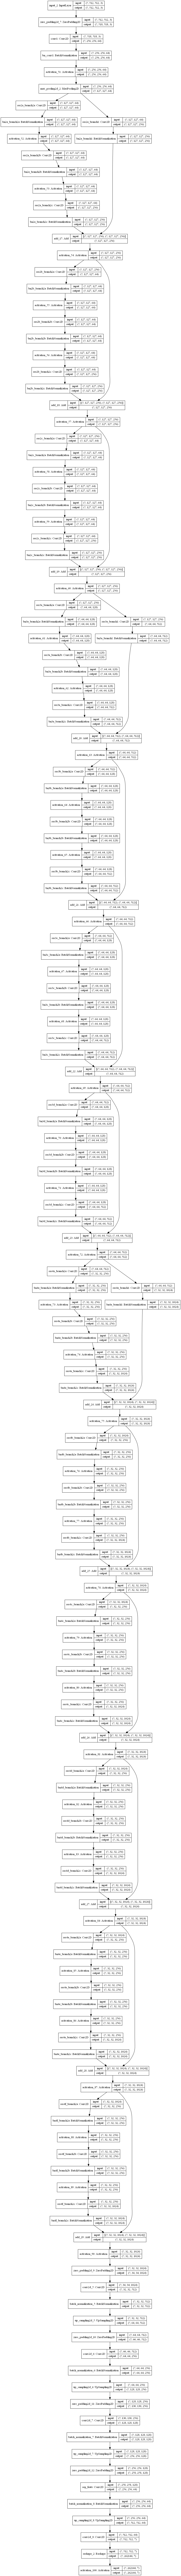

In [26]:
tf.keras.utils.plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [22]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [23]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [24]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 244s 476ms/step - loss: 0.6412 - iou_score: 0.3139 - f1-score: 0.4573 - val_loss: 0.3604 - val_iou_score: 0.5427 - val_f1-score: 0.6845

Epoch 00001: val_iou_score improved from -inf to 0.54267, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 2/100
512/512 [==============================] - 231s 451ms/step - loss: 0.5474 - iou_score: 0.4010 - f1-score: 0.5554 - val_loss: 0.5955 - val_iou_score: 0.5538 - val_f1-score: 0.6928

Epoch 00002: val_iou_score improved from 0.54267 to 0.55377, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_segnet.hdf5
Epoch 3/100
512/512 [==============================] - 226s 442ms/step - loss: 0.5219 - iou_score: 0.4265 - f1-score: 0.5801 - val_loss: 0.2943 - val_iou_score: 0.5716 - val_f1-score: 0.7098

Epoch 00003: val_iou_score improved from 0.55377 to 0.57163, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Be

## Saving the model

In [25]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

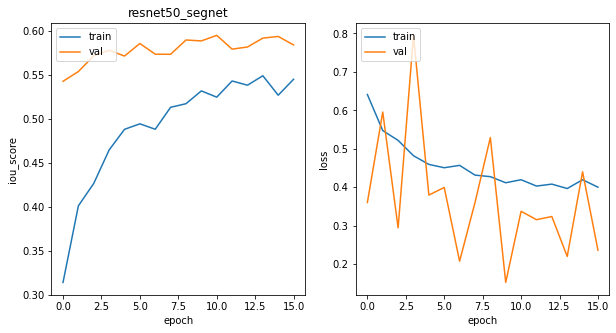

In [36]:
plot_history(nn_model,model_balanced_name[i])

In [46]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

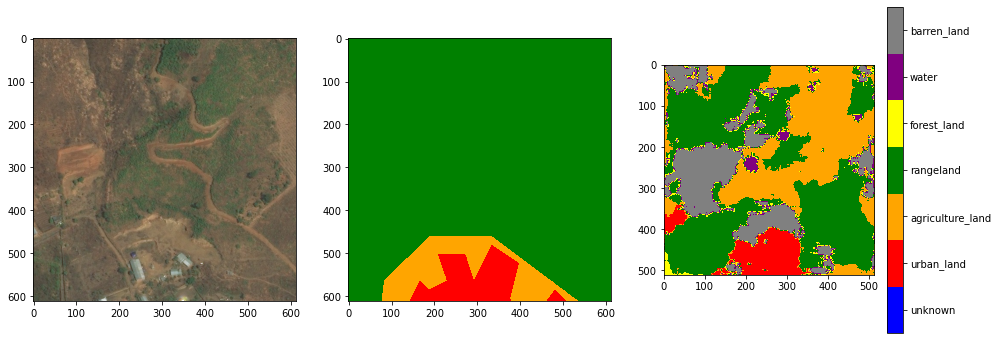

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# VGG_Segnet

In [32]:
i = 1

In [33]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [34]:
model = vgg_segnet(n_classes=7 , input_height=512, input_width=512)

In [35]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.002864


In [36]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [37]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 211s 412ms/step - loss: 0.5962 - iou_score: 0.3590 - f1-score: 0.5096 - val_loss: 0.2161 - val_iou_score: 0.5524 - val_f1-score: 0.6896

Epoch 00001: val_iou_score improved from -inf to 0.55244, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_segnet.hdf5
Epoch 2/100
512/512 [==============================] - 221s 432ms/step - loss: 0.4953 - iou_score: 0.4522 - f1-score: 0.6077 - val_loss: 0.2131 - val_iou_score: 0.5863 - val_f1-score: 0.7227

Epoch 00002: val_iou_score improved from 0.55244 to 0.58634, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_segnet.hdf5
Epoch 3/100
512/512 [==============================] - 204s 398ms/step - loss: 0.4798 - iou_score: 0.4680 - f1-score: 0.6216 - val_loss: 0.4259 - val_iou_score: 0.5801 - val_f1-score: 0.7131

Epoch 00003: val_iou_score did not improve from 0.58634
Epoch 4/100
512/512 [==============================] - 207s 404ms/step - lo

## Saving the model

In [42]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

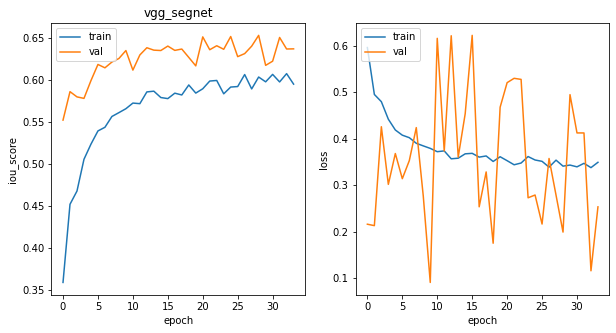

In [43]:
plot_history(nn_model,model_balanced_name[i])

In [44]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

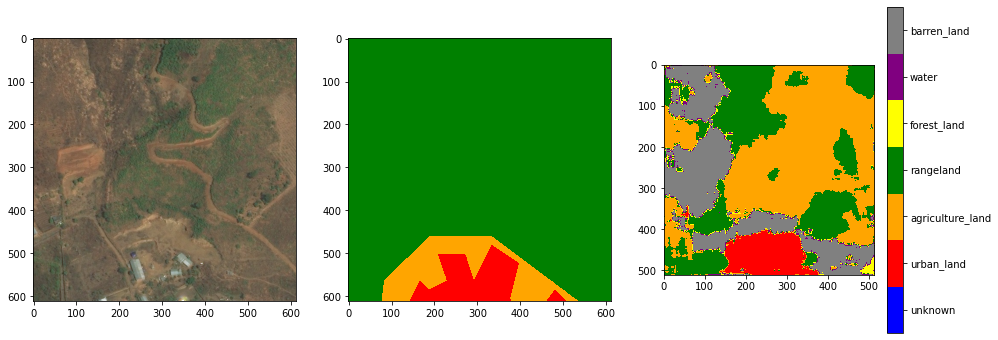

In [45]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# VGG_Unet

In [46]:
i = 2

In [47]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

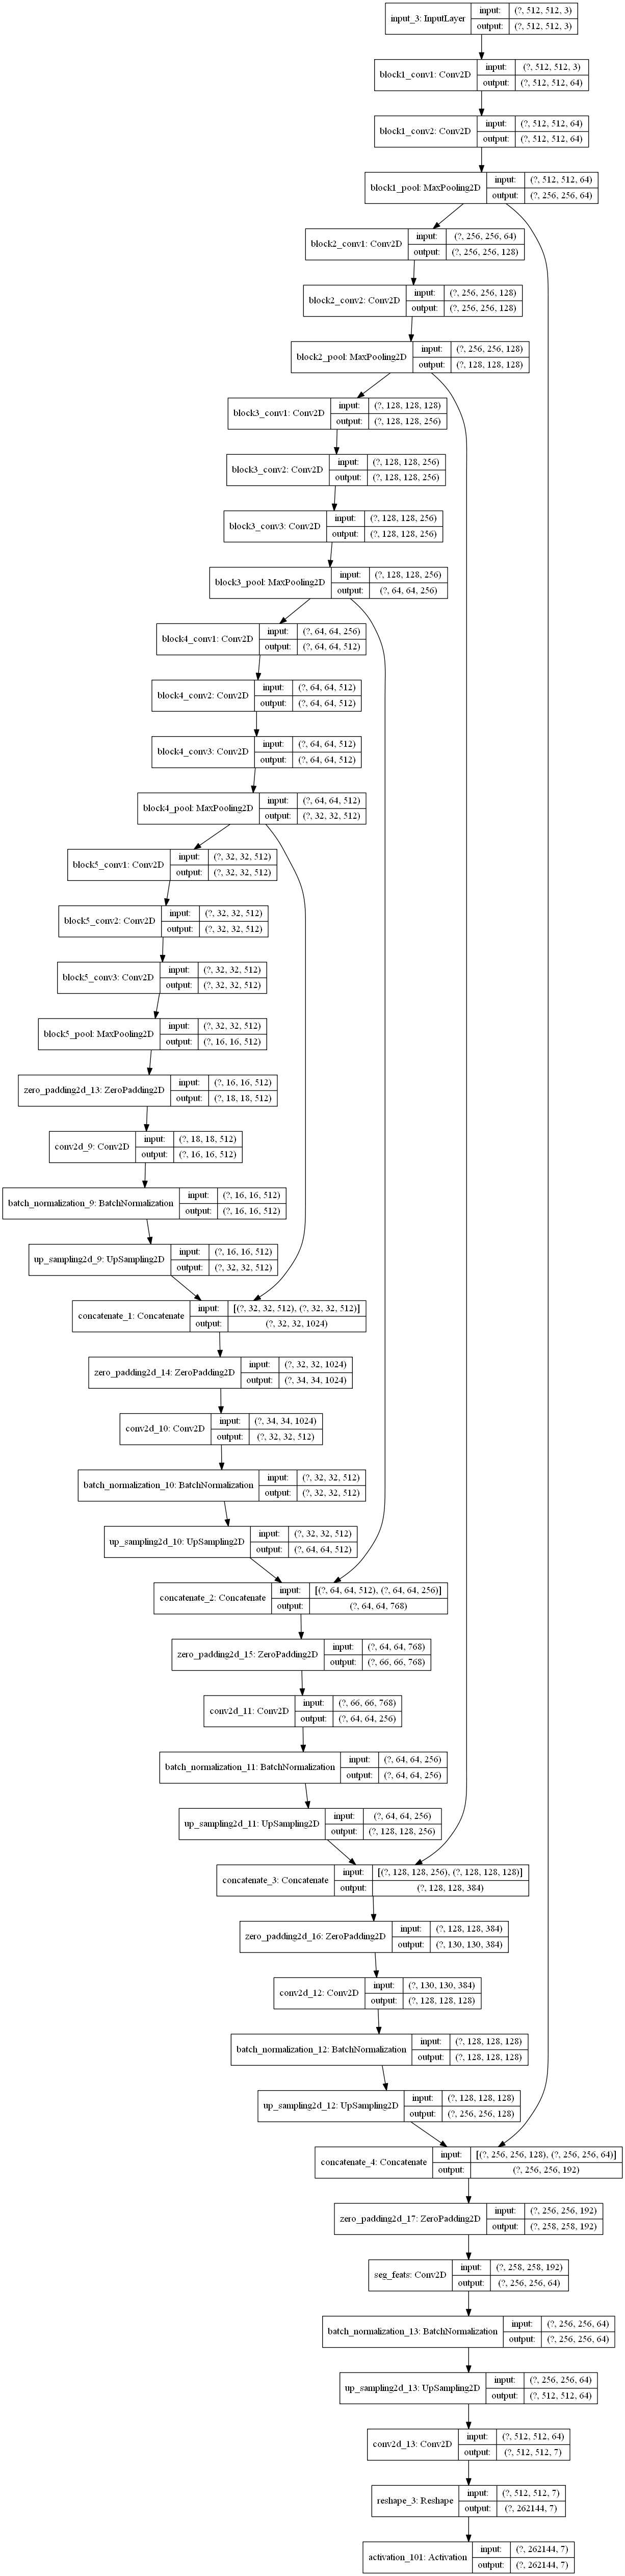

In [27]:
model = vgg_unet(n_classes=7 , input_height=512, input_width=512)
tf.keras.utils.plot_model(model,to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [49]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.009546


In [50]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [51]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 234s 458ms/step - loss: 0.8517 - iou_score: 0.1064 - f1-score: 0.1861 - val_loss: 0.9150 - val_iou_score: 0.2407 - val_f1-score: 0.3711

Epoch 00001: val_iou_score improved from -inf to 0.24074, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_unet.hdf5
Epoch 2/100
512/512 [==============================] - 229s 447ms/step - loss: 0.7761 - iou_score: 0.1964 - f1-score: 0.3161 - val_loss: 0.6168 - val_iou_score: 0.3071 - val_f1-score: 0.4490

Epoch 00002: val_iou_score improved from 0.24074 to 0.30713, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_unet.hdf5
Epoch 3/100
512/512 [==============================] - 229s 448ms/step - loss: 0.7506 - iou_score: 0.2251 - f1-score: 0.3532 - val_loss: 0.4192 - val_iou_score: 0.3248 - val_f1-score: 0.4706

Epoch 00003: val_iou_score improved from 0.30713 to 0.32476, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg

## Saving the model

In [52]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

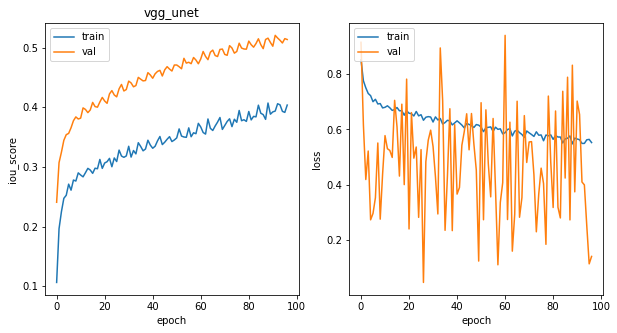

In [53]:
plot_history(nn_model,model_balanced_name[i])

In [54]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

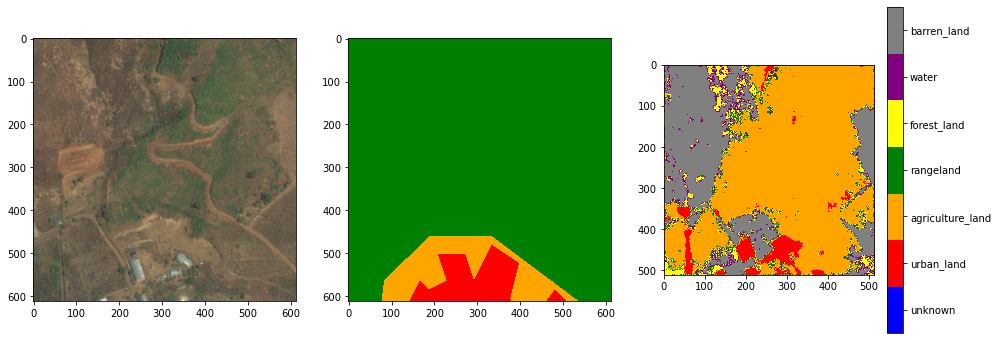

In [55]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# ResNet_Unet

In [56]:
i = 3

In [57]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [58]:
model = resnet50_unet(n_classes=7 , input_height=512, input_width=512)

In [59]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.006682


In [60]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [61]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 297s 580ms/step - loss: 0.8438 - iou_score: 0.0991 - f1-score: 0.1735 - val_loss: 0.4156 - val_iou_score: 0.3422 - val_f1-score: 0.4907

Epoch 00001: val_iou_score improved from -inf to 0.34217, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_unet.hdf5
Epoch 2/100
512/512 [==============================] - 282s 550ms/step - loss: 0.7271 - iou_score: 0.2341 - f1-score: 0.3656 - val_loss: 0.4892 - val_iou_score: 0.4428 - val_f1-score: 0.5886

Epoch 00002: val_iou_score improved from 0.34217 to 0.44282, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_unet.hdf5
Epoch 3/100
512/512 [==============================] - 281s 549ms/step - loss: 0.6631 - iou_score: 0.3007 - f1-score: 0.4466 - val_loss: 0.6996 - val_iou_score: 0.5014 - val_f1-score: 0.6442

Epoch 00003: val_iou_score improved from 0.44282 to 0.50138, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_W

## Saving the model

In [62]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

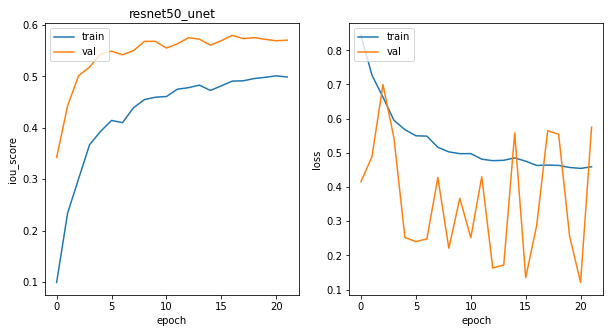

In [63]:
plot_history(nn_model,model_balanced_name[i])

In [64]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

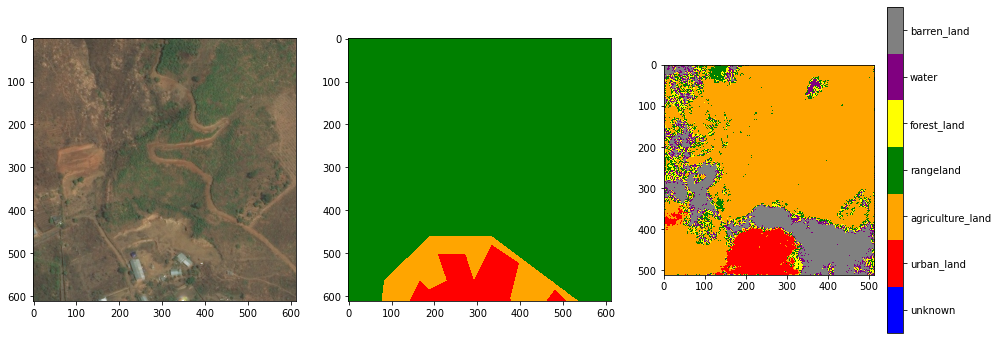

In [65]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# resnet50_pspnet

In [66]:
i = 4

In [67]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [68]:
model = resnet50_pspnet(n_classes=7 , input_height=576, input_width=576)

In [69]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.008592


In [70]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [71]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 222s 434ms/step - loss: 0.6546 - iou_score: 0.2820 - f1-score: 0.3998 - val_loss: 0.3300 - val_iou_score: 0.5005 - val_f1-score: 0.6353

Epoch 00001: val_iou_score improved from -inf to 0.50054, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_pspnet.hdf5
Epoch 2/100
512/512 [==============================] - 209s 409ms/step - loss: 0.5143 - iou_score: 0.4304 - f1-score: 0.5730 - val_loss: 0.9491 - val_iou_score: 0.5640 - val_f1-score: 0.6952

Epoch 00002: val_iou_score improved from 0.50054 to 0.56404, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_resnet50_pspnet.hdf5
Epoch 3/100
512/512 [==============================] - 214s 418ms/step - loss: 0.4559 - iou_score: 0.4821 - f1-score: 0.6249 - val_loss: 0.0651 - val_iou_score: 0.5618 - val_f1-score: 0.6957

Epoch 00003: val_iou_score did not improve from 0.56404
Epoch 4/100
512/512 [==============================] - 206s 401ms

## Saving the model

In [72]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

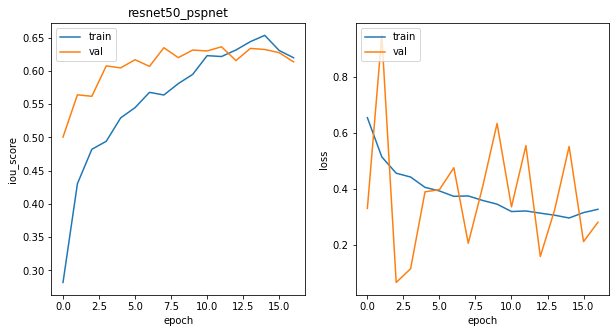

In [73]:
plot_history(nn_model,model_balanced_name[i])

In [74]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

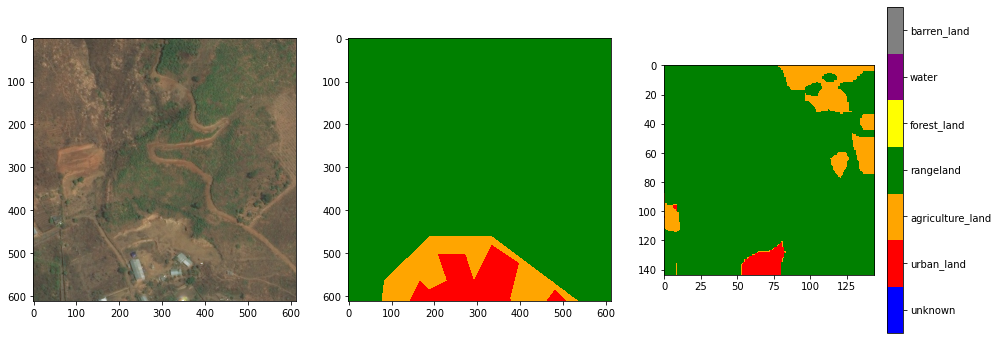

In [75]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')

# vgg_pspnet

In [23]:
i = 5

In [24]:
callbacks = [
    ModelCheckpoint(monitor='val_iou_score',
                filepath= '../../models/'f'{folder_name}''/' + 'Model_Best_Weights_'f'{model_balanced_name[i]}''.hdf5',
                        save_best_only=True,
                        verbose=1, mode = 'max'), 
    EarlyStopping(monitor='val_iou_score',patience=5,
                           restore_best_weights=True,
                           mode='max'),
    ReduceLROnPlateau(monitor='val_iou_score', factor=0.5,
                              patience=3, min_lr=0.000001),
   # tf.keras.callbacks.TensorBoard(log_dir='./logs', profile_batch=5)
]

In [26]:
model = vgg_pspnet(n_classes=7 , input_height=576, input_width=576)
model.summary()

Model: "model_12"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 576, 576, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 576, 576, 64) 1792        input_3[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 576, 576, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 288, 288, 64) 0           block1_conv2[0][0]               
___________________________________________________________________________________________

In [89]:
from datetime import datetime
start = datetime.now()
total_loss, optim, metrics,  train_gen,  steps_per_epoch, val_gen, val_steps_per_epoch, epochs, callbacks, gen_use_multiprocessing, initial_epoch = model.train(
    input_height = 612,
    input_width = 612,
    learn_rate=0.00001,
    verify_dataset = False,
    train_images =  '../../data/processed/'f'{folder_dataset}''/train/Images/',
    train_annotations = '../../data/processed/'f'{folder_dataset}''/train/Masks/',
    validate= True,
    val_images =  '../../data/processed/'f'{folder_dataset}''/val/Images/',
    val_annotations = '../../data/processed/'f'{folder_dataset}''/val/Masks/',
    epochs=100, 
    callbacks = callbacks,
#     other_inputs_paths = ['../../data/processed/'f'{folder_dataset}''/Sample_Weights/']
)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))


Time Taken for testing: 0:00:00.003818


In [90]:
optima = Adam(lr=0.00001)
model.compile(loss=total_loss, optimizer= optima, metrics= metrics)

In [91]:
start = datetime.now()
nn_model = model.fit(train_gen,
                  steps_per_epoch=steps_per_epoch,
                  validation_data=val_gen,
                  validation_steps=val_steps_per_epoch,
                  epochs=epochs, callbacks=callbacks,
                  use_multiprocessing=gen_use_multiprocessing, initial_epoch=initial_epoch) #, sample_weight = sample_weight)
end = datetime.now()
print("\nTime Taken for testing: %s" % (end-start))

Epoch 1/100
512/512 [==============================] - 179s 349ms/step - loss: 0.5890 - iou_score: 0.3575 - f1-score: 0.4878 - val_loss: 0.3956 - val_iou_score: 0.5866 - val_f1-score: 0.7122

Epoch 00001: val_iou_score improved from -inf to 0.58664, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_pspnet.hdf5
Epoch 2/100
512/512 [==============================] - 175s 341ms/step - loss: 0.4514 - iou_score: 0.4923 - f1-score: 0.6357 - val_loss: 0.6601 - val_iou_score: 0.6101 - val_f1-score: 0.7337

Epoch 00002: val_iou_score improved from 0.58664 to 0.61008, saving model to ../../models/Save_Balanced_80_SM_JP/Model_Best_Weights_vgg_pspnet.hdf5
Epoch 3/100
512/512 [==============================] - 175s 342ms/step - loss: 0.4097 - iou_score: 0.5320 - f1-score: 0.6719 - val_loss: 0.8488 - val_iou_score: 0.3899 - val_f1-score: 0.5174

Epoch 00003: val_iou_score did not improve from 0.61008
Epoch 4/100
512/512 [==============================] - 179s 350ms/step - lo

## Saving the model

In [92]:
model.save('../../models/'f'{folder_name}''/' + 'Model_Save_Model_'f'{model_balanced_name[i]}''.h5')

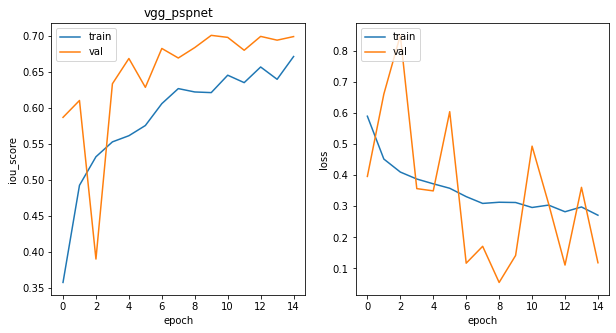

In [93]:
plot_history(nn_model,model_balanced_name[i])

In [94]:
out = model.predict_segmentation(
    inp= reading_images[img_num],
    out_fname= '../../models/'f'{folder_name}''/' + 'Model_'f'{model_balanced_name[i]}''.png'
)

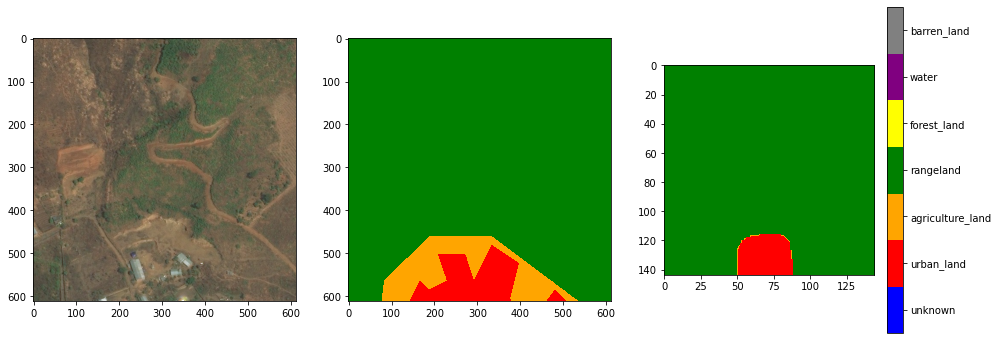

In [95]:
fig, axes = plt.subplots(1, 3, figsize=(16, 6))

axes[0].imshow(np.asarray(img))
axes[1] = visualize.plot_label(np.asarray(mask), labels,col_dict, axes[1], fig, colorbar = False)
axes[2] = visualize.plot_label(np.asarray(out), labels,col_dict, axes[2], fig, colorbar = True)
plt.savefig('../../models/'f'{folder_name}''/' + 'Model_Comparison_'f'{model_balanced_name[i]}''.png')